# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy

In [2]:
from torch.utils.tensorboard import SummaryWriter

# Dataset

In [3]:
with open('../../model/config.json', 'rb') as file:
    config = json.load(file)
csop_cols_to_ignore = config['csop']['cols_to_ignore']
csopII_cols_to_ignore = config['csopII']['cols_to_ignore']
csop_target, csopII_target = 'zscore_efficiency', 'efficiency'

In [4]:
csop_raw = pd.read_csv('../../output/csop_output_conversation_level.csv')
csop_all_features = csop_raw.drop(csop_cols_to_ignore, axis=1)
target_scaler = StandardScaler()
csop_all_features['target'] = target_scaler.fit_transform(csop_raw[csop_target].to_numpy().reshape(-1, 1))

csopII_raw = pd.read_csv('../../output/csopII_output_conversation_level.csv')
csopII_all_features = csopII_raw.drop(csopII_cols_to_ignore, axis=1)
csopII_all_features['target'] = target_scaler.transform(csopII_raw[csopII_target].to_numpy().reshape(-1, 1))

features = list(set(csop_all_features.columns).intersection(set(csopII_all_features.columns)))
csop, csopII = csop_all_features[features].copy(), csopII_all_features[features].copy()
csop, csopII = csop.fillna(0), csopII.fillna(0)

In [5]:
X, y = csop.drop(['target'], axis=1), csop[['target']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_test, y_test = csopII.drop(['target'], axis=1), csopII[['target']]

feature_scaler = StandardScaler()
X_train = pd.DataFrame(feature_scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns)
X_val = pd.DataFrame(feature_scaler.transform(X_val.to_numpy()), columns=X_val.columns)
X_test = pd.DataFrame(feature_scaler.transform(X_test.to_numpy()), columns=X_test.columns)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((882, 390), (98, 390), (962, 390), (882, 1), (98, 1), (962, 1))

In [6]:
feature_groupings_raw = pd.read_excel('feature_groupings_06_20_23.xlsx')
groups = feature_groupings_raw.columns[2:]
groups

Index(['Communication Frequency', 'Information / Knowledge Exchange',
       'Linguistic Features', 'Emotion', 'Cognitive Processes',
       'Perceptual Processes', 'Social Processes', 'Biological Processes',
       'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
       'Hedging', 'Politeness', 'Equality'],
      dtype='object')

In [7]:
rows = []
for idx, row in tqdm(feature_groupings_raw.iterrows(), total=feature_groupings_raw.shape[0]):
    if row['Level'] == 'Chat':
        for prefix in ['min_', 'max_', 'stdev_', 'average_']:
            feature_name = prefix + row['Feature Name']
            row_to_append = [feature_name] + row[groups].to_list()
            rows.append(row_to_append)
    else:
        feature_name = row['Feature Name']
        row_to_append = [feature_name] + row[groups].to_list()
        rows.append(row_to_append)
feature_groupings = pd.DataFrame(
    rows, 
    columns= [
        'Feature Name', 'Communication Frequency', 'Information / Knowledge Exchange',
        'Linguistic Features', 'Emotion', 'Cognitive Processes',
        'Perceptual Processes', 'Social Processes', 'Biological Processes',
        'Personal Concerns', 'Accommodation/\nMimicry', 'Temporal', 'Question',
        'Hedging', 'Politeness', 'Equality'
    ]
)

100%|██████████| 99/99 [00:00<00:00, 1455.41it/s]


## Creating Data Loaders

In [8]:
class CSOPDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [9]:
train_dataset = CSOPDataset(X=X_train.to_numpy(), y=y_train.to_numpy())
val_dataset = CSOPDataset(X=X_val.to_numpy(), y=y_val.to_numpy())

In [10]:
torch.manual_seed(42)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)

# Fully Connected Neural Network Optimization

## Helper Functions

In [11]:
class CSOPFullyConnectedNN(nn.Module):
    def __init__(self, num_input_features, num_hidden_layer_nodes=15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=num_input_features, out_features=num_hidden_layer_nodes),
            nn.ReLU(),
            nn.Linear(in_features=num_hidden_layer_nodes, out_features=1)
        )

    def forward(self, X):
        return self.net(X)

In [12]:
num_hidden_layer_nodes = list(range(1, 101))
models = [CSOPFullyConnectedNN(num_input_features=X_train.shape[1], num_hidden_layer_nodes=num_hidden_layer_node) \
          for num_hidden_layer_node in num_hidden_layer_nodes]
model_names = ['num_hidden_nodes_'+str(num_nodes) for num_nodes in num_hidden_layer_nodes]
learning_rates = [0.000001, 0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
max_epochs_list = [50, 100, 250, 500, 1000]

In [13]:
def train(model, num_hidden_layer_neurons=15, learning_rate=0.00003, max_epochs=200):
    best_mse = float('inf')
    best_weights = None
    train_losses, val_losses = [], []

    loss_fn = nn.MSELoss()
    optimizer = Adam(params=model.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):
        # Training for one epoch
        model.train()
        train_loss = 0
        for (X_batch, y_batch) in train_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            # Weights Updates
            optimizer.step()
            train_loss += float(loss)
        # Calculating average training loss after one epoch
        avg_train_mse_loss = float(train_loss/len(train_dataloader))
        train_losses.append(avg_train_mse_loss)
        # writer.add_scalar('Training Loss', avg_train_mse_loss, epoch)
        # Validation after one epoch
        model.eval()
        val_loss = 0
        for X_batch, y_batch in val_dataloader:
            # Forward Pass
            X_batch, y_batch = X_batch.to(torch.float32), y_batch.to(torch.float32)
            y_pred = model(X_batch)
            val_mse_loss = loss_fn(y_pred, y_batch)
            val_loss += float(val_mse_loss)
        # Calculating average validation loss after one epoch
        avg_val_mse_loss = float(val_loss/len(val_dataloader))
        val_losses.append(avg_val_mse_loss)
        # writer.add_scalar('Validation Loss', avg_val_mse_loss, epoch)
        # Checking if we improved from the previous best epoch
        if avg_val_mse_loss < best_mse:
            best_mse = avg_val_mse_loss
            best_weights = copy.deepcopy(model.state_dict())
            best_epoch = epoch
    
    model.load_state_dict(best_weights)
    model_cache = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': min(val_losses),
        'num_hidden_layer_neurons': num_hidden_layer_neurons,
        'learning_rate': learning_rate,
        'max_epochs': max_epochs,
        'best_epoch': best_epoch
    }
    return model_cache

In [18]:
model_performances = pd.DataFrame(
    columns=[
        'model', 'num_hidden_layer_neurons', 
        'learning_rate', 'max_epochs', 
        'best_epoch', 'best_val_loss',
        'train_losses', 'val_losses'
    ]
)
for num_hidden_layer_neurons, model in tqdm(enumerate(models), total=len(models)):
    for learning_rate in learning_rates:
        for max_epoch in max_epochs_list:
            model_cache = train(
                model=model, 
                num_hidden_layer_neurons=num_hidden_layer_neurons, 
                learning_rate=learning_rate, 
                max_epochs=max_epoch
            )
            model_performances = model_performances.append({
                'model': model_cache['model'],
                'num_hidden_layer_neurons': model_cache['num_hidden_layer_neurons'],
                'learning_rate': model_cache['learning_rate'],
                'max_epochs': model_cache['max_epochs'],
                'best_epoch': model_cache['best_epoch'],
                'best_val_loss': model_cache['best_val_loss'],
                'train_losses': model_cache['train_losses'],
                'val_losses': model_cache['val_losses']
            }, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/xt/g8l4wmks0vdfkcs7td5kd6dh0000gn/T/ipykernel_42437/2816263979.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performances = model_performances.append({
/var/folders/xt/g8l4wmks0vdfkcs7td5kd6dh0000gn/T/ipykernel_42437/2816263979.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performances = model_performances.append({
/var/folders/xt/g8l4wmks0vdfkcs7td5kd6dh0000gn/T/ipykernel_42437/2816263979.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performances = model_performances.append({
/var/folders/xt/g8l4wmks0vdfkcs7td5kd6dh0000gn/T/ipykernel_42437/2816263979.py:18: FutureWarning: The frame.append method is deprecated and will be removed from

In [19]:
import pickle
with open('model_performances.pkl', 'wb') as file_handle:
    pickle.dump(model_performances, file_handle)

with open('model_performances.pkl', 'rb') as file_handle:
    model_performances_loaded = pickle.load(file_handle)

In [24]:
(model_performances == model_performances_loaded)

,model,num_hidden_layer_neurons,learning_rate,max_epochs,best_epoch,best_val_loss,train_losses,val_losses
0,False,True,True,True,True,True,True,True
1,False,True,True,True,True,True,True,True
2,False,True,True,True,True,True,True,True
3,False,True,True,True,True,True,True,True
4,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...
3995,False,True,True,True,True,True,True,True
3996,False,True,True,True,True,True,True,True
3997,False,True,True,True,True,True,True,True
3998,False,True,True,True,True,True,True,True


In [23]:
best_model_cache

{'model': CSOPFullyConnectedNN(
   (net): Sequential(
     (0): Linear(in_features=390, out_features=100, bias=True)
     (1): ReLU()
     (2): Linear(in_features=100, out_features=1, bias=True)
   )
 ),
 'train_losses': [0.9345375831638064,
  0.8810388616153172,
  0.8554071996893201,
  0.8415268212556839,
  0.8181717566081456,
  0.8105103437389646,
  0.800641587802342,
  0.7919933987515313,
  0.7943286257130759,
  0.7836518904992512,
  0.7844670968396323,
  0.7769739329814911,
  0.7720882083688464,
  0.7772811310631889,
  0.7746629459517342,
  0.7670050774301801,
  0.7612157676901136,
  0.757600588457925,
  0.7586818635463715,
  0.759267155613218,
  0.7533087879419327,
  0.7510448332343783,
  0.7501377803938729,
  0.7469066892351423,
  0.7469791131360191,
  0.743740547980581,
  0.7515141580786023,
  0.7421729394367763,
  0.745241471699306,
  0.7410108659948621,
  0.7396414854696819,
  0.7346982040575573,
  0.738543084689549,
  0.7351396701165608,
  0.7397864907979965,
  0.732358919722

In [28]:
model_path = f'feature_bagging_nn_models/fully_connected_nn_best_model_optimized'
torch.save(best_model_cache['model'], model_path)

In [24]:
def calc_nn_metrics(y_true, y_pred, type='TRAIN'):
    r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
    rmse = np.sqrt(mse).round(4)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)

    print(f'{type} METRICS')
    print(f'R2: {r2}\tMSE: {mse}\tRMSE: {rmse}\tMAE: {mae}')

In [25]:
train_preds = best_model_cache['model'](torch.tensor(X_train.to_numpy(), dtype=torch.float32)).detach().numpy()
val_preds = best_model_cache['model'](torch.tensor(X_val.to_numpy(), dtype=torch.float32)).detach().numpy()

In [26]:
calc_nn_metrics(y_true=y_train, y_pred=train_preds, type='TRAIN')

TRAIN METRICS
R2: 0.3142	MSE: 0.6773	RMSE: 0.823	MAE: 0.5784


In [27]:
calc_nn_metrics(y_true=y_val, y_pred=val_preds, type='VALIDATION')

VALIDATION METRICS
R2: 0.3232	MSE: 0.7465	RMSE: 0.864	MAE: 0.667


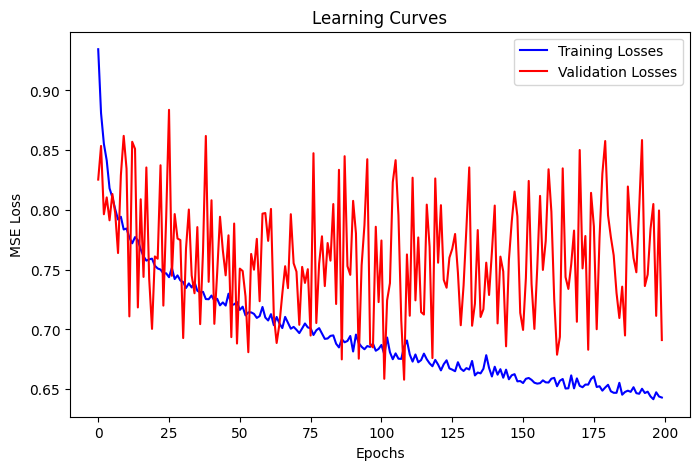

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(best_model_cache['train_losses'], color='blue', label='Training Losses')
ax.plot(best_model_cache['val_losses'], color='red', label='Validation Losses')
ax.legend()
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Learning Curves')
plt.show()